In [21]:
import modern_robotics as mr
import numpy as np

np.set_printoptions(suppress=True)
from dataclasses import dataclass
from tpk4170.visualization import Kr6R900SixxVisualizer

## Visualize Denavit-Hartenberg frames

### 1) Definitions

In [22]:
@dataclass
class DHLink:
    a: float
    alpha: float
    d: float
    theta: float

    def matrix(self) -> np.array:
        ct = np.cos(self.theta)
        st = np.sin(self.theta)
        ca = np.cos(self.alpha)
        sa = np.sin(self.alpha)
        return np.array(
            [
                [ct, -st * ca, st * sa, self.a * ct],
                [st, ct * ca, -ct * sa, self.a * st],
                [0.0, sa, ca, self.d],
                [0.0, 0.0, 0.0, 1.0],
            ]
        )

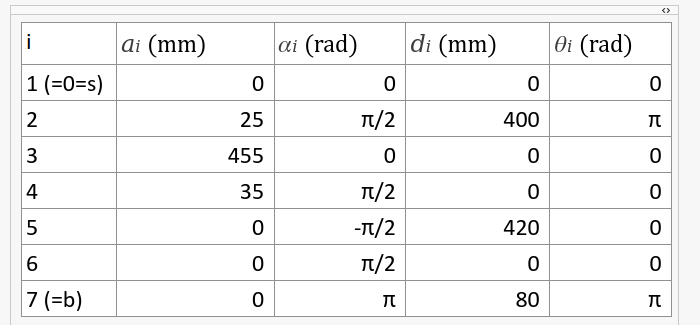

In [24]:
# define DH parameters for each link in meters

# CAUTION MAYBE ONE LINK TO MUCH ?
# IF YES WHICH FRAME SHOULD WE REMOVE ?

PI = np.pi
PI_HALF = np.pi/2

l1 = DHLink(0.0,   0.0,      0.0,   0.0)
l2 = DHLink(0.025, PI_HALF,  0.400, PI)
l3 = DHLink(0.455, 0.0,      0.0,   0.0)
l4 = DHLink(0.035, PI_HALF,  0.0,   0.0)
l5 = DHLink(0.0,   -PI_HALF, 0.420, 0.0)
l6 = DHLink(0.0,   PI_HALF,  0.0,   0.0)
l7 = DHLink(0.0,   PI,       0.080, PI)


In [32]:
# small verification with visualization
fk_dh_zero = (
    l1.matrix()
    @ l2.matrix()
    @ l3.matrix()
    @ l4.matrix()
    @ l5.matrix()
    @ l6.matrix()
    @ l7.matrix()
)
print(fk_dh_zero)

[[ 1.     0.    -0.    -0.515]
 [ 0.     1.     0.     0.   ]
 [ 0.     0.     1.    -0.1  ]
 [ 0.     0.     0.     1.   ]]


In [77]:
v = Kr6R900SixxVisualizer()

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

In [58]:
v.theta = np.array([0, 0, 0, 0, 0, 0])

In [78]:
direction = [0.0, 1.0, 0.0]
origin = [0.025, -0.4, 0.4]

v._viewer.add(ScrewAxis(direction, origin, .4))



### 2) Visualization of DH frames

In [52]:
from tpk4170.visualization import Viewer
from tpk4170.models import Grid, Axes
from pythreejs import Object3D
from transformations import quaternion_from_matrix

from pythreejs import ArrowHelper as Arrow

In [70]:
class DHFrame(Axes):
    def __init__(self, trf):
        Axes.__init__(self, 0.1)
        self.quaternion = np.roll(quaternion_from_matrix(trf), -1).tolist()
        self.position = (trf[:3, 3]).tolist()
        
class ScrewAxis(Arrow):
    def __init__(self, direction, origin, length, color=0xffff00):
        Arrow.__init__(self, direction, origin, hex=color)
        

In [82]:
kr6_vis = Kr6R900SixxVisualizer()
kr6_vis.theta = np.array([0, 0, PI_HALF, 0, 0, 0])

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

In [43]:
viewer = Viewer(background="white")

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

In [45]:
T01 = l1.matrix()
T02 = T01 @ l2.matrix()
T03 = T02 @ l3.matrix()
T04 = T03 @ l4.matrix()
T05 = T04 @ l5.matrix()
T06 = T05 @ l6.matrix()
T07 = T06 @ l7.matrix()

In [46]:
viewer.add(Grid())
viewer.add(DHFrame(T01))
viewer.add(DHFrame(T02))
viewer.add(DHFrame(T03))
viewer.add(DHFrame(T04))
viewer.add(DHFrame(T05))
viewer.add(DHFrame(T06))
viewer.add(DHFrame(T07))

## Visualize space frame and body frame screw axes

In [17]:
class Kr6:
    W1 = 0.10915
    W2 = 0.0823
    L1 = 0.425
    L2 = 0.39225
    H1 = 0.089159
    H2 = 0.09465

    def __init__(self):
        # TO DEFINE FOR KR6
        self._M = np.array(
            [
                [-1.0, 0.0, 0.0, self.L1 + self.L2],
                [0.0, 0.0, 1.0, self.W1 + self.W2],
                [0.0, 1.0, 0.0, self.H1 - self.H2],
                [0.0, 0.0, 0.0, 1.0],
            ]
        )
        
        # TO DEFINE FOR KR6
        self._SList = np.array(
            [
                [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, -self.H1, 0.0, 0.0],
                [0.0, 1.0, 0.0, -self.H1, 0.0, self.L1],
                [0.0, 1.0, 0.0, -self.H1, 0.0, self.L1 + self.L2],
                [0.0, 0.0, -1.0, -self.W1, self.L1 + self.L2, 0.0],
                [0.0, 1.0, 0.0, self.H2 - self.H1, 0.0, self.L1 + self.L2],
            ]
        ).T

    def fkin(self, theta):
        return mr.FKinSpace(self._M, self._SList, theta)


PI_HALF = np.pi / 2
PI = np.pi